# Подключение библиотек и Google диска


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google

import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем
import colorsys 

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


# Глобальные параметры


In [ ]:
path         = '/content/drive/My Drive/Cats Detection/cats data/' # Путь к директории на диске
images_path  = path + 'images/'  # Путь к директории на диске, где находятся изображения
labels_path  = path + 'labels/'  # Путь к директории на диске, где находятся метки
weights_path = path + 'weights/' # Путь к директории на диске, где находятся веса модели
images_test  = path + 'tests/'   # Путь к директории на диске, где находятся тестовые изображения
font_path    = path              # Путь к директории на диске, где находится шрифт
name_classes = ['cat'] # Названия классов
num_classes  = len(name_classes) # Количество классов
w_img, h_img = 832, 832
input_shape  = (w_img, h_img) # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[20, 26], [32, 60], [66, 46], [60, 122], [124, 90], [118, 238], [232, 180], [312, 396], [746, 652]]) 
num_anchors = len(anchors) # Сохраняем количество анкоров

# Создание модели

## Функции

In [ ]:
'''
    Функция создания полной модели
        Входные параметры:       
          input_shape - размерность входного изображения для модели YOLO
          num_anchors - общее количество анкоров   
          use_weights - использовать ли предобученные веса         
          weights_path - путь к сохраненным весам модели  
'''
def create_model(
        input_shape,
        num_anchors,
        use_weights = False, 
        weights_path = 'yolo.h5'        
        ):
    w, h = input_shape # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [ ]:
'''
Функция создания модели YOLOv3 https://www.youtube.com/watch?v=LyReVtfA6ok&t=7570s
    Входные параметры:
          inputs - Входной слой модели
          num_sub_anchors - количество анкоров в каждом уровне сеток
'''
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    #--------------------
    # Базовая часть модели YOLOv3
    #--------------------
    
    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок использующий информацию из предыдущих слоев.
    # С помощью слоя Add (Суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3)) # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1) # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2) # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8) # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8) # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4) # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x) # Создаем базовую часть модели YOLOv3
    
    #--------------------
    # Detection часть модели YOLOv3
    #--------------------
    
    # Выделяем три выхода сети, соответсвующих различным уровням сетки
    
    
    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    
    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    
    # 26x26 (обнаружение средних объектов)
    
    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объеденить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, использую UpSampling
    x = Concatenate()([x, base_model.layers[152].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    # 52 x 52 (обнаружение маленьких объектов)
    
    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объеденить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)  # Увеличиваем размерность до 52 на 52, использую UpSampling
    x = Concatenate()([x,base_model.layers[92].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [ ]:
''' Функция создания Residual блока. https://www.youtube.com/watch?v=LyReVtfA6ok&t=7180s
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          num_filters - количество нейронов
          num_blocks  - количество блоков 
 '''
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) # Добавляем блок ConvBL
    for i in range(num_blocks): # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

In [ ]:
''' Функция создания блока Conv2D, BatchNormalization, LeakyRelu https://www.youtube.com/watch?v=LyReVtfA6ok&t=7055s
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          args - массив неименованных параметров
          kwargs  - массив именованных параметров
 '''
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False} # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x) # Добавляем слой LeakyRelu
    return x

In [ ]:
'''
Функция подсчета ошибки. https://www.youtube.com/watch?v=LyReVtfA6ok&t=8105s
    Входные параметры:
        inputs - Входные данные
        num_anchors - общее количество анкоров                    
'''
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3 # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers] # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:] # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] # Задаем маску анкоров для каждого уровня сеток
    # ([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]])
   
    
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 


        # l1
        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка

        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # l2
        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        

        # l3
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask # Увеличиваем счетчик на еденицу и возвращаем ignore_mask
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонента - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        #l4
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

In [ ]:
'''
    Функция подсчета IoU https://www.youtube.com/watch?v=LyReVtfA6ok&t=10575s
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    xy1 = input1[..., :2] # Получаем координаты x,y центра 
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соотвествующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    xy2 = input2[..., :2] # Получаем координаты x,y центра 
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соотвествующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU
    

## Основной код

In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors)

Создана модель YOLOv3. Количество классов: 1.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<KerasTensor: shape=(None, 832, 832, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 104, 104, 3, 6) dtype=float32 (created by layer 'input_4')>]

In [ ]:
# Выводим выходныую размерность модели
model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели
# model_YOLO.summary()

# Обучение модели

## Функции

In [ ]:
# Функция генерации данных
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    while True:
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        for b in range(batch_size): # Пробегаем по всему batch_size
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            image, box = augmentation(annotation_lines[i]) # Делаем аугментацию картинок и ограничивающих рамок
            image_data.append(image) # Добавляем полученную картинку в результирующий массив 
            box_data.append(box) # Добавляем полученную ограничивающую рамку в массив bounfing_box
            i = (i+1) % n # Обновляем значение индека (не превышая общего количества элементов)
        image_data = np.array(image_data) # Преобразуем в numpy
        box_data = np.array(box_data) # Преобразуем в numpy
        y_true = get_y(box_data, anchors, input_shape) # По значению ограничивающей рамки получаем y_true        
        yield [image_data, *y_true], np.zeros(batch_size) # Возвращаем порцию данных для обучения

In [ ]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    data = data.split() # Сплитим входную строку словаря
    image = Image.open(images_path + data[0]) # Открываем изображение
    width_i, height_i = image.size # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2] # Получаем ширину и высоту входного изображения для модели RetinaNet
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 8 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5)
    box = np.reshape(box, (-1, 5))
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    # Возвращаем изменные изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box

In [ ]:
# Функция подсчета y
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32') # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32') # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] # Получаем высоту и ширину bounding_box В относительных значениях

    m = true_boxes.shape[0] # Получаем количество элементов в batch_size
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue # Выходим если она нулевая
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [ ]:
# Создание словаря {Имя файла: параметры файла}
def get_dict():
    images = sorted(os.listdir(images_path)) # Получаем список файлов картинок
    labels = sorted(os.listdir(labels_path)) # Получаем список файлов меток
    #dictionary = {i:[] for i in images} # Создаем пустой словарь
    dictionary = {}
    class_id = 0 # Задаем параметр номера класса
    for f in images:
        image = Image.open(images_path + f) # Открываем изображение
        iw, ih = image.size # Запоминаю оригинальные размеры изображения
        xy = []
        label = []
        l = labels[images.index(f)]
        for i in open(labels_path + l, 'r'):
            label.append(i[:-1])
        for lbl in label:
            annot = lbl.split(' ')
            if int(annot[0]) == 0:
                xy.append(int((float(annot[1]) - float(annot[3])/2)*iw))
                xy.append(int((float(annot[2]) - float(annot[4])/2)*ih))
                xy.append(int((float(annot[1]) + float(annot[3])/2)*iw))
                xy.append(int((float(annot[2]) + float(annot[4])/2)*ih))
                xy.append(int(annot[0]))

        key = f # Получаем ключ словаря (имя файла)
        s = ''
        for d in xy:
            # print(d)
            s += str(d) + ','
            # s += (str(d[0])+','+str(d[1])+','+str(d[2])+','+str(d[3])+','+str(d[4])+',')
        dictionary[key] = key + ' ' + s[:-1] # Записываем значения в словарь

    # Выводим сообщение о заврешении обработки
    print ('Завершена обработка класса: ', name_classes[0])
        
    return dictionary # Возвращаем словарь

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

## Подготовка данных

In [ ]:
import json
dictionary_file = path + 'dictionary.json'
with open(dictionary_file, 'r') as read_file: # Читаю файл с помощью библиотеки json
    dictionary = json.load(read_file)

In [ ]:
dictionary_np = np.array(list(dictionary.values())) # Создаем numpy массив из значений словаря
print ('Количество изображений:', len(dictionary)) # Отображаем количество элементов в словаре
num_val = 20 # Количество элементов проверочной выборки
num_train = 200 # Количество элементов обучающей выборки

Количество изображений: 220


## Обучение с различными шагами


### lr_value = 1e-3 50 эпох

In [ ]:
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # clipnorm=1 для Adam

# Запускаем процесс обучения на 25 эпохах
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета
model_filename = weights_path + 'YOLO/YOLOv3_bs4_1e3_025.h5' # Указываем имя файла для сохранения модели
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 25,
                    verbose = 1,
                    initial_epoch = 0)

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).    to_csv(weights_path + 'YOLO/loss_4_025.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(weights_path + 'YOLO/valloss_4_025.csv') # Сохраняем проверочную выборку

print ('Время обработки: ' + str(round(time.time() - startTime)) + ' сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/25
50/50 [==============================] - 157s 3s/step - loss: 4730.0469 - val_loss: 987362496.0000
Epoch 2/25
50/50 [==============================] - 83s 2s/step - loss: 470.2224 - val_loss: 4203944.0000
Epoch 3/25
50/50 [==============================] - 85s 2s/step - loss: 257.7587 - val_loss: 580.2983
Epoch 4/25
50/50 [==============================] - 85s 2s/step - loss: 173.4720 - val_loss: 289.1302
Epoch 5/25
50/50 [==============================] - 86s 2s/step - loss: 130.0384 - val_loss: 191.8878
Epoch 6/25
50/50 [==============================] - 85s 2s/step - loss: 97.2066 - val_loss: 126.3217
Epoch 7/25
50/50 [==============================] - 84s 2s/step - loss: 78.8413 - val_loss: 89.8505
Epoch 8/25
50/50 [==============================] - 85s 2s/step - loss: 67.6092 - val_loss: 72.9493
Epoch 9/25
50/50 [==============================] - 85s 2s/step - loss: 58.9165 - val_loss: 61.6770
Epoch 10/25
50/50 [==============================] - 84s 2s/step - loss: 53.2

In [ ]:
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и компилируем
model_weight =  weights_path +'YOLO/YOLOv3_bs4_1e3_025.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # clipnorm=1 для Adam

# Запускаем процесс обучения на 25 эпохах
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета
model_filename = weights_path + 'YOLO/YOLOv3_bs4_1e3_050.h5' # Указываем имя файла для сохранения модели
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 25)

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).    to_csv(weights_path + 'YOLO/loss_4_050.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(weights_path + 'YOLO/valloss_4_050.csv') # Сохраняем проверочную выборку

print ('Время обработки: ' + str(round(time.time() - startTime)) + ' сек') # Отображаем время, потраченное на процесс обучения

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Defect Detection/cats data/weights832/YOLO/YOLOv3_bs4_1e3_025.h5.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 26/50
50/50 [==============================] - 184s 3s/step - loss: 100.2406 - val_loss: 1291936384.0000
Epoch 27/50
50/50 [==============================] - 87s 2s/step - loss: 29.2133 - val_loss: 248508.9531
Epoch 28/50
50/50 [==============================] - 86s 2s/step - loss: 26.0800 - val_loss: 52.0387
Epoch 29/50
50/50 [==============================] - 88s 2s/step - loss: 24.8122 - val_loss: 25.3852
Epoch 30/50
50/50 [==============================] - 86s 2s/step - loss: 24.4940 - val_loss: 25.3243
Epoch 31/50
50/50 [==============================] - 85s 2s/step - loss: 23.8004 - val_loss: 22.6679
Epoch 32/50
50/50 [==============================] - 85s 2s/step - loss: 23.1969 - val_loss: 21.8146
Epoch 33/50
50/50 [==============================] - 85s 2s/step - loss: 22.2860 - val_loss: 21.5478
Epoch 34/50
50/50 [==============================] - 85s 2s/step - loss: 21.9600 - val_loss: 22.5690
Epoch 35/50
50/50 [==============================] - 85s 2s/step - loss: 21.4

### lr_value = 1e-4 50 эпох

In [ ]:
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
model_weight =  weights_path +'YOLO/YOLOv3_bs4_1e3_050.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

# Запускаем процесс обучения еще на 50 эпохах
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 # Задаем размер пакета
model_filename = weights_path +'YOLO/YOLOv3_bs4_1e4_100.h5' # Указываем имя файла для сохранения модели
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).    to_csv(weights_path + 'YOLO/loss_4_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(weights_path + 'YOLO/valloss_4_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Defect Detection/cats data/weights832/YOLO/YOLOv3_bs4_1e3_050.h5.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
50/50 [==============================] - 100s 2s/step - loss: 21.7281 - val_loss: 18.2306
Epoch 2/50
50/50 [==============================] - 86s 2s/step - loss: 18.3570 - val_loss: 17.3311
Epoch 3/50
50/50 [==============================] - 86s 2s/step - loss: 18.2773 - val_loss: 18.9240
Epoch 4/50
50/50 [==============================] - 86s 2s/step - loss: 21.1798 - val_loss: 15.8008
Epoch 5/50
50/50 [==============================] - 86s 2s/step - loss: 17.5912 - val_loss: 19.2503
Epoch 6/50
50/50 [==============================] - 86s 2s/step - loss: 17.0673 - val_loss: 19.7769
Epoch 7/50
50/50 [==============================] - 86s 2s/step - loss: 16.3864 - val_loss: 20.8188
Epoch 8/50
50/50 [==============================] - 86s 2s/step - loss: 16.5567 - val_loss: 16.7529
Epoch 9/50
50/50 [==============================] - 86s 2s/step - loss: 16.4101 - val_loss: 19.6993
Epoch 10/50
50/50 [==============================] - 88s 2s/step - loss: 16.5784 - val_loss: 18.811

### lr_value = 1e-5 50 эпох

In [ ]:
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и компилируем
model_weight =  weights_path +'YOLO/YOLOv3_bs4_1e4_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

# Запускаем процесс обучения на 50 эпохах
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета
model_filename = weights_path +'YOLO/YOLOv3_bs4_1e5_150.h5' # Указываем имя файла для сохранения модели
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).    to_csv(weights_path + 'YOLO/loss_4_150.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(weights_path + 'YOLO/valloss_4_150.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Defect Detection/cats data/weights832/YOLO/YOLOv3_bs4_1e4_150.h5.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
50/50 [==============================] - 201s 3s/step - loss: 13.1632 - val_loss: 12.5963
Epoch 2/50
50/50 [==============================] - 141s 3s/step - loss: 13.2858 - val_loss: 12.1064
Epoch 3/50
50/50 [==============================] - 140s 3s/step - loss: 12.8173 - val_loss: 11.8650
Epoch 4/50
50/50 [==============================] - 140s 3s/step - loss: 13.0911 - val_loss: 12.3648
Epoch 5/50
50/50 [==============================] - 141s 3s/step - loss: 13.2665 - val_loss: 11.9518
Epoch 6/50
50/50 [==============================] - 140s 3s/step - loss: 13.0121 - val_loss: 12.1337
Epoch 7/50
50/50 [==============================] - 140s 3s/step - loss: 13.1776 - val_loss: 12.8943
Epoch 8/50
50/50 [==============================] - 140s 3s/step - loss: 13.0992 - val_loss: 12.0186
Epoch 9/50
50/50 [==============================] - 140s 3s/step - loss: 12.8707 - val_loss: 12.0980
Epoch 10/50
50/50 [==============================] - 140s 3s/step - loss: 13.3214 - val_los

# Предикт

## Библиотеки

In [ ]:
import cv2
from tqdm import tqdm_notebook
from tensorflow.keras.models import load_model

## Функции

In [ ]:
def size2modelSize(image, modelSize):
    image = Image.fromarray(image)
    iw, ih = image.size
    w, h = modelSize
    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)
    resImage = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', (w, h), (128, 128, 128))
    new_image.paste(resImage, ((w - nw) // 2, (h - nh) // 2))
    resImage = new_image
    resImage = np.array(resImage) / 255.
    return resImage.reshape(1, w, h, 3)

In [ ]:
def getGrid(shape):
    #grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
    grid = [] # Массив для финальной сетки
    grid_row = [] # Массив для столбца
    for i in range(shape[0]): # По всем строкам
        for j in range(shape[1]): # По всем столбцам
            grid_row.append([j , i]) # Создаем элемент [j, i]
        grid.append(grid_row) # Добавляем столбец в финальную сетку
        grid_row = [] # Обнуляем данные для столбца
    grid = np.array(grid) # Переводим в numpy
    return np.expand_dims(grid, axis=2) # Добавляем размерность

In [ ]:
# Функция расчета сигмоиды для вектора
def sigmoid(x): # На вход подаем массив данных
    return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива

In [ ]:
def get6params(feats, grid, anchors_tensor, image_shape, input_shape ):
    
    xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
    box_xy = (sigmoid(xy_param) + grid)/grid.shape[0:2] # Получаем координаты центра bounding box

    # Высота и ширна bounding box
    wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
    box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

    # Вероятность наличия объекта в анкоре
    conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
    box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

    # Класс объекта
    class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
    box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

    # Корректируем ограничивающие рамки (Размер изображения на выходе 416х416)
    # И найденные параметры соответствуют именно этой размерности
    # Необходимо найти координаты bounding box для рамерности исходного изображения
    box_yx = box_xy[..., ::-1].copy()
    box_hw = box_wh[..., ::-1].copy()

    new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
    offset = (input_shape-new_shape)/2./input_shape # Смотрим, на сколько надо сместить в относительных координатах
    scale = input_shape/new_shape  # Находим коэффициент масштабирования
    box_yx = (box_yx - offset) * scale # Смещаем по координатам
    box_hw *= scale # Масштабируем ширину и высоту

    box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
    box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
    _boxes =  np.concatenate([
        box_mins[..., 0:1], # yMin
        box_mins[..., 1:2], # xMin
        box_maxes[..., 0:1], # yMax
        box_maxes[..., 1:2]  # xMax
    ], axis=-1)
    _boxes *= np.concatenate([image_shape, image_shape])

    _boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
    _box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
    _box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив
    return _boxes_reshape, _box_scores_reshape


In [ ]:
def non_max_suppression_fast(boxes, scores, overlapThresh):	
    
    if len(boxes) == 0: # Если нет ни одного бокса
        return []

    pick = [] # Индексы возвращаемых боксов
    
    x1 = boxes[:,0] # координаты x левых верхних углов
    y1 = boxes[:,1] 
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last],
                                            np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int"), scores[pick]

In [ ]:
def detection (image, model, score=0.1, overlapThresh=0.15): 

    # Создаем набор цветов для ограничивающих рамок
    
    hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
    np.random.seed(43)
    np.random.shuffle(colors)
    np.random.seed(None)

    model_image_size = (832,832) # Задаем размер входных данных
    image_for_predict = size2modelSize(image, model_image_size)

    ###
    #       Предиктим картинку
    ###
    predict = model.predict(image_for_predict)
    num_layers = len(predict) # Получаем количество сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
    input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
    image_shape = np.array([image.shape[0], image.shape[1]]) # Сохраняем размер оригинального изображения

    ###
    #       Обрабатываем предикт (все уровни анкоров)
    ###
    all_boxes = np.zeros((0,4))
    all_scores = np.zeros((0,1))
    for level_anchor in range(num_layers):
        num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров

        grid = getGrid(predict[level_anchor].shape[1:3]) # Получаем сетку  
        
        anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
        anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим

        # Решейпим предикт
        feats = np.reshape(predict[level_anchor], (-1, grid.shape[0], grid.shape[1], num_anchors, num_classes+5))

        # Получаем боксы
        _boxes_reshape, _box_scores_reshape = get6params(feats, grid, anchors_tensor, image_shape, input_shape)
        all_boxes = np.concatenate((all_boxes, _boxes_reshape))
        all_scores = np.concatenate((all_scores, _box_scores_reshape))

    # Задаем маску вероятности
    mask = all_scores >= score # Берем все объекты, обнаруженные с вероятностью больше 0.7

    _boxes_out = all_boxes[mask[:,0]]
    _scores_out = all_scores[:, 0][mask[:,0]] 
    classes_out = np.ones_like(_scores_out,'int32') * 0

    font = ImageFont.truetype(font=font_path + 'font.otf',
                        size=np.floor(3e-2 * image.shape[0] + 0.5).astype('int32'))
    thickness = (image.shape[1] + image.shape[0]) // 300

    try:
        new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, overlapThresh)
        new_classes = np.ones_like(new_scores,'int32') * 0
        
        image_pred = Image.fromarray(image)

        for i, c in reversed(list(enumerate(new_classes))):
            draw = ImageDraw.Draw(image_pred)
            predicted_class = name_classes[c]
            box = new_boxes[i]
            score = new_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])
            
            for i in range(thickness):
                draw.rectangle(
                        [left + i, top + i, right - i, bottom - i],
                        outline=colors[c])
            draw.rectangle(
                    [tuple(text_origin), tuple(text_origin + label_size)],
                    fill=colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        return np.array(image_pred)
    except:
        return image


## Предикт на картинке

In [ ]:
model_weight = weights_path + 'YOLO/YOLOv3_bs4_1e5_250.h5' # Указываем файл с весами модели
max_boxes = 8 # Максимальное количество ограничивающих рамок на изображении
model = create_YOLOv3(Input(shape=(w_img, h_img, 3)), 9//3) # Создаем модель
model.load_weights(model_weight) # Загружаем посчитанные веса модели

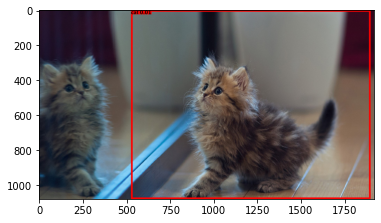

In [ ]:
image = np.array(Image.open(images_test + 'cat test 1.jpg')) # Загружаем изображение

image_pred = detection(image, model, 0.01, 0.01)
if (image_pred is None): print ('Не обнаружено!')
else: plt.imshow(image_pred)

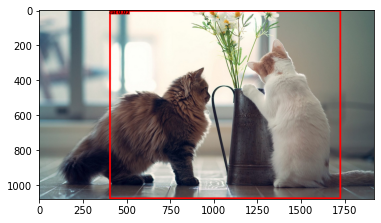

In [ ]:
image = np.array(Image.open(images_test + 'cat test 2.jpg')) # Загружаем изображение

image_pred = detection(image, model, 0.01, 0.01)
if (image_pred is None): print ('Не обнаружено!')
else: plt.imshow(image_pred)

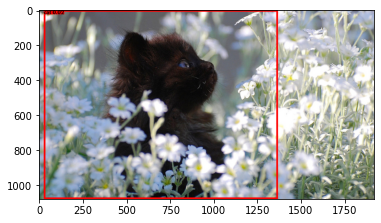

In [ ]:
image = np.array(Image.open(images_test + 'cat test 3.jpg')) # Загружаем изображение

image_pred = detection(image, model, 0.01, 0.01)
if (image_pred is None): print ('Не обнаружено!')
else: plt.imshow(image_pred)

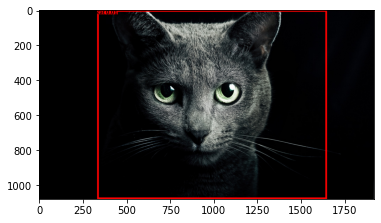

In [ ]:
image = np.array(Image.open(images_test + 'cat test 4.jpg')) # Загружаем изображение

image_pred = detection(image, model, 0.01, 0.01)
if (image_pred is None): print ('Не обнаружено!')
else: plt.imshow(image_pred)

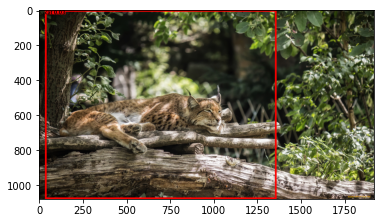

In [ ]:
image = np.array(Image.open(images_test + 'cat test 5.jpg')) # Загружаем изображение

image_pred = detection(image, model, 0.01, 0.01)
if (image_pred is None): print ('Не обнаружено!')
else: plt.imshow(image_pred)

## Предикт на видео

In [ ]:
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2605056/45929032 bytes (5.7%)6479872/45929032 bytes (14.1%)10444800/45929032 bytes (22.7%)14147584/45929032 bytes (30.8%)17973248/45929032 bytes (39.1%)21463040/45929032 bytes (46.7%)25100288/45929032 bytes (54.7%)28704768/45929032 bytes (62.5%)32235520/45929032 bytes (70.2%)36003840/45929032 bytes (78.4%)39616512/45929032 bytes (86.3%)41984000/45929032 bytes (91.4%)

In [ ]:
# -i          Что?
# -ss         Начиная с какой секунды?
# -t          Какой интервал взять?
# -c copy     Куда?

# 00:00:30.00 - 00:00:15.00

!ffmpeg -i '/content/drive/My Drive/Defect Detection/cats data/tests/Cats 1080.mp4' -ss 00:00:30.00 -t 00:00:20.00 -c copy C1080.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
video_ = '/content/C1080.mp4'

In [ ]:
# Создаем класс для чтения видео
video_reader = cv2.VideoCapture(video_)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h   = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w   = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
fps       = int(video_reader.get(cv2.CAP_PROP_FPS))

images = []

for i in tqdm_notebook(range(fps*15)): # Обработаем 15 секунд видео

    # Обрабатываем каждый фрейм видео    
    _, img = video_reader.read()
    # Конвертируем BGR -> RGB
    img = img[:,:, ::-1]
    # По каждому кадру делаем предикт
    image_pred = detection(img, model, 0.01, 0.01)
    # Конвертируем RGB -> BGR 
    image_pred = image_pred[:,:, ::-1]

    images.append(image_pred)

  0%|          | 0/435 [00:00<?, ?it/s]

In [ ]:
# Создаем заготовку под видео
# https://www.fourcc.org/codecs.php

video_writer = cv2.VideoWriter('/content/drive/My Drive/Defect Detection/cats data/tests/Predict 1080_832.avi',
                            cv2.VideoWriter_fourcc(*'MPEG'), 
                            25.0, 
                            (frame_w, frame_h))

# собираем все кадры в видео
for i in range(len(images)):
    video_writer.write(images[i])

# Ставим "точку", завершаем
video_reader.release()
video_writer.release()